# Toy Experiment with Irregular Sine Data

In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
from argparse import Namespace
from data.irregular_sine_provider import IrregularSineProvider


In [2]:
dataset = "irregular_sine_interpolation"
experiment_id = 9518
log_file = f"../logs/{dataset}_{experiment_id}.json"

In [3]:
# load logfile
import json
with open(log_file,'r') as f:
    logs = json.load(f)

In [4]:
# print experiment settings
from pprint import pprint
pprint(logs['args'])

{'checkpoint_at': [90, 390, 990, 4500],
 'checkpoint_dir': 'checkpoints',
 'device': 'cuda:0',
 'enable_checkpointing': True,
 'enable_file_logging': True,
 'freeze_sigma': True,
 'h_dim': 3,
 'kl0_weight': 0.001,
 'klp_weight': 0.01,
 'learnable_prior': False,
 'log_dir': 'logs/',
 'loglevel': 'debug',
 'lr': 0.001,
 'mc_eval_samples': 1,
 'mc_train_samples': 1,
 'n_deg': 6,
 'n_epochs': 4500,
 'pxz_weight': 1.0,
 'restart': 30,
 'seed': -1,
 'z_dim': 3}


In [5]:
# print final values
from pprint import pprint
pprint(logs['final'])

{'epoch': 4500,
 'trn_elbo': 1.238790381679349,
 'trn_kl0': 5.860796928405762,
 'trn_klp': 2316.417236328125,
 'trn_log_pxz': -3.3493863943511175,
 'trn_loss': 1.238790381679349,
 'trn_mse_full': 0.009337285533547401,
 'trn_mse_impt': 0.009337285533547401}


In [6]:
# plot loss curves
import matplotlib.pyplot as plt
def plot_stat(logs: dict, stat:str, modes:list = ['trn']):
    fig, ax = plt.subplots(figsize=(8,3))
    for mode in modes:
        key = f"{mode}_{stat}"
        val = logs['all'][key]
        ax.plot(val, label = mode)
    ax.set_xlabel('training epochs')
    ax.set_ylabel(stat)
    ax.grid()
    return fig, ax

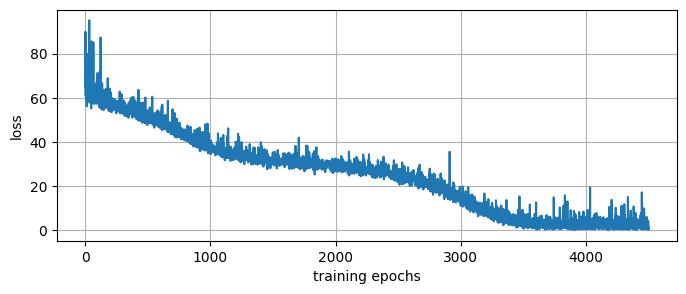

In [7]:
plot_stat(logs, 'loss');

In [8]:
args = Namespace(**logs['args'])

provider = IrregularSineProvider(num_samples=1)
dl_trn = provider.get_train_loader(batch_size=1)
batch = next(iter(dl_trn))

In [9]:
from core.models import ToyRecogNet, ToyReconNet, PathToGaussianDecoder, default_SOnPathDistributionEncoder

desired_t = torch.linspace(0, 1.0, provider.num_timepoints, device=args.device)

recog_net = ToyRecogNet(args.h_dim)
recon_net = ToyReconNet(args.z_dim)
qzx_net = default_SOnPathDistributionEncoder(
        h_dim=args.h_dim,
        z_dim=args.z_dim,
        n_deg=args.n_deg,
        learnable_prior=args.learnable_prior,
        time_min=0.0,
        time_max=2.0 * desired_t[-1].item(),
    )
pxz_net = PathToGaussianDecoder(mu_map=recon_net, sigma_map=None, initial_sigma=np.sqrt(0.05))

modules = nn.ModuleDict(
    {
        "recog_net": recog_net,
        "recon_net": recon_net,
        "pxz_net": pxz_net,
        "qzx_net": qzx_net,
    }
)
modules = modules.to(args.device)

In [10]:
# load_model
epoch = 4500
checkpoint = f"../checkpoints/checkpoint_{experiment_id}_{epoch}.h5"
checkpoint = torch.load(checkpoint)
modules.load_state_dict(checkpoint['modules'])

<All keys matched successfully>

In [11]:
# generate reconstructions
dl = dl_trn
device = args.device
modules = modules.to(device)
for _, batch in enumerate(dl):
    parts = {key: val.to(device) for key, val in batch.items()}
    inp = (parts["inp_obs"], parts["inp_msk"], parts["inp_tps"])
    h = modules["recog_net"](inp)
    qzx, pz = modules["qzx_net"](h, desired_t)
    zis = qzx.rsample((500,))
    pxz = modules["pxz_net"](zis)
    break


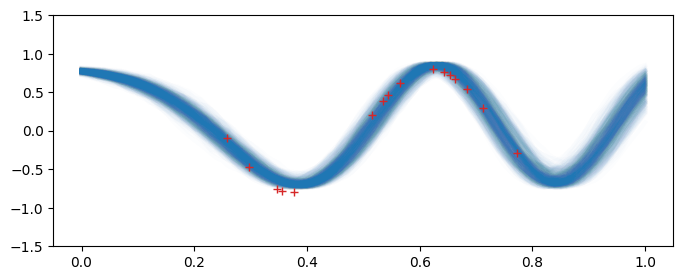

In [12]:
plt.figure(figsize=(8,3))
for i in range(500):
    plt.plot(torch.arange(101)/100
    , pxz.mean[i].flatten().detach().cpu(),color='tab:blue', alpha=0.01, linewidth=3)
plt.plot(batch['evd_tid'].flatten()/101,batch['evd_obs'].flatten(),'+', color='tab:red')
plt.ylim(-1.5,1.5);

In [13]:
t = qzx.t.cpu().detach()
latents = qzx.sample((500,)).cpu().detach()

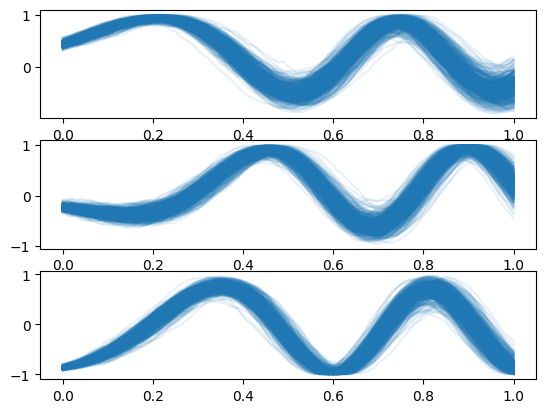

In [14]:
fig, ax = plt.subplots(3)
for i in range(3):
    ax[i].plot(t, latents[:,0,:,i].permute(1,0), color='tab:blue', alpha=0.1)

In [15]:
endat = 101
for current_at in range(endat):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    print(current_at)
    for idx in range(len(latents)):
        ax.plot(latents[idx,0,:current_at,0],latents[idx,0,:current_at,1],latents[idx,0,:current_at,2], c='tab:blue',alpha=.1)
        ax.scatter(latents[idx,0,0,0],latents[idx,0,0,1],latents[idx,0,0,2], c='tab:red', alpha=.1)
        ax.scatter(latents[idx,0,current_at,0],latents[idx,0,current_at,1],latents[idx,0,current_at,2], c='tab:red', alpha=.1)

    # sphere = np.random.randn(50000,3)
    # sphere = sphere / np.linalg.norm(sphere, axis=1, keepdims=True)
    # ax.scatter(sphere[:,0], sphere[:,1],sphere[:,2], s=.01)

    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="k", alpha=.2)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_aspect("equal")
    ax.axis('off');
    fig.savefig(f'/tmp/sphere/sphere_{current_at:04d}.png', dpi=150)
    plt.close();

0


/scratch1/rkwitt/anaconda3/envs/pytorch113/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/scratch1/rkwitt/anaconda3/envs/pytorch113/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.arra

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
